In [184]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
from tqdm import tqdm
import datetime as dt
from datetime import time
import math
from datetime import datetime

In [185]:
def reader(path, first_var):
    '''
    Reads SEMS/DASH data, adds datetime columns

    :param path: path to data file
    :param first_var: the name of the fir column label
    :return: pandas DataFrame
    '''
    # Open the file and read the lines
    skip=1
    with open(path, "r") as file:
        # Iterate over the lines
        for line in file:
            # rip leading and trailing whitespace
            line = line.strip()
            # Check if the line contains column names
            if line.startswith(first_var):
                # Split the line by whitespace and append to the columns list
                columns = line[1:].strip().split("\t")
                break
            skip+=1
    # Read the data into a DataFrame, skipping the first 6 rows of comments
    d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns, low_memory=False)
    #Check for duplicated metadata, remove metadata rows based on string "OPC SN"
    if len(d)>0:
        if isinstance(d.iloc[0,0], str):
            dup_meta = [n for n, i in enumerate(d.iloc[:,0]) if 'OPC SN' in i]
            if len(dup_meta) > 0:
                for line in dup_meta:
                    #Deletes duplicate metadata rows from dataframe
                    d.drop(np.arange(line,line+68), inplace = True)
                    # Apply the function to each column
                    d_og = d.copy()
                    for c in d.keys():
                        try:
                            d[c] = pd.to_numeric(d_og[c])
                        except:
                            d[c] = d_og[c]
                    #d = d.apply(pd.to_numeric, ‘raise’,)
                    
    # Creates datetime columns
    if 'DOY.Frac' in d.keys():
        d['dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['DOY.Frac'], unit='D') - pd.Timedelta(days=1)
    if 'StartTimeSt' in d.keys():
        d['st_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['StartTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'EndTimeSt' in d.keys():
        d['end_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['EndTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'YY/MM/DD' and 'HR:MN:SC' in d.keys():
        d['dt'] = pd.to_datetime(str(20) + d['YY/MM/DD'] + ' ' + d['HR:MN:SC'], format='%Y/%m/%d %H:%M:%S')
    return d

In [186]:
def glob_reader(file_key, first_var, subfolder = './data/'):
    '''
    Reads groups of data files and merges them into one

    :param file_key: shared key in filenames
    :param first_var: the name of the first column label
    :param subfolder: name of the subfolder containing the data
    :return: pandas DataFrame
    '''
    paths = sorted(glob.glob(subfolder+'*'+file_key+'*'))
    d = []
    for i in range(0, len(paths)):
        f = reader(paths[i], first_var)
        if len(f)>0:
            d.append(f)
    d = pd.concat(d).reset_index()
    return d

In [187]:
def read_all_data():

    folders = sorted(glob.glob('./data/DASH-flight*'))

    dopc = []
    hopc = []
    dash = []
    sems = []

    for i in range(0, len(folders)):
        path = folders[i] + '/'
        dopc.append(glob_reader('OPC_212', '#YY/MM/DD', subfolder = path).drop_duplicates(subset='dt', keep='first'))
        hopc.append(glob_reader('OPC_210', '#YY/MM/DD', subfolder = path).drop_duplicates(subset='dt', keep='first'))
        dash.append(glob_reader('DASH_FLOW', '#DOY.Frac', subfolder = path).drop_duplicates(subset='dt', keep='first'))
        sems.append(glob_reader('SEMS_DATA', '#DOY.Frac', subfolder = path).drop_duplicates(subset='dt', keep='first'))
    
    dopc = pd.concat(dopc, ignore_index=True)
    hopc = pd.concat(hopc, ignore_index=True)
    dash = pd.concat(dash, ignore_index=True)
    sems = pd.concat(sems, ignore_index=True)
    
    # merge the DataFrames based on the DOPC times
    merged = pd.merge_asof(dopc, hopc, on='dt', direction = 'nearest', tolerance=timedelta(seconds=1)).drop(columns=['index_x'])
    merged = pd.merge_asof(merged, dash, on='dt', direction = 'nearest', tolerance=timedelta(seconds=1))
    merged = pd.merge_asof(merged, sems, on='dt', direction = 'nearest', tolerance=timedelta(seconds=1)).drop_duplicates(subset='dt', keep='first').dropna().reset_index()

    return merged

In [188]:
def retrieve_flows(d):
    
    # filter out for flight times
    d_out = pd.DataFrame()
    f_ac = 0
    for _, row in ft.iterrows():
        mask = (d['dt'] >= row['LARGE_Filter_Off_UTC']) & (d['dt'] <= row['LARGE_Filter_On_UTC'])
        filtered = d.loc[mask]
        d_out = pd.concat([d_out, filtered], ignore_index=True)
    d_out['input_flow_lpm'] = d_out['UpSt_Samp']

    for i, row in ls.iterrows():
        if row['LARGE_To'] == 'OFF':
            mask = (d_out['dt'] >= row['Switch_Start_UTC']) & (d_out['dt'] <= ls.loc[i+1,'Switch_Stop_UTC'])
            d_out.loc[mask,'input_flow_lpm'] = 0
        elif row['LARGE_To'] == 'DASH':
            mask = (d_out['dt'] >= row['Switch_Start_UTC']) & (d_out['dt'] <= row['Switch_Stop_UTC'])
            d_out.loc[mask,'input_flow_lpm'] = 0
            print(len(d_out.loc[mask,'input_flow_lpm']))
            mask = (d_out['dt'] >= row['Switch_Stop_UTC']) & (d_out['dt'] <= ls.loc[i+1,'Switch_Stop_UTC'])
            d_out.loc[mask,'input_flow_lpm'] = d_out.loc[mask,'HM_Smp_Xs']
        elif row['LARGE_To'] == 'SEMS':
            mask = (d_out['dt'] >= row['Switch_Start_UTC']) & (d_out['dt'] <= row['Switch_Stop_UTC'])
            d_out.loc[mask,'input_flow_lpm'] = 0
    
    output = pd.DataFrame(data={'datetime_UTC':d_out['dt'], 'input_flow_lpm':d_out['input_flow_lpm']})

    return output.drop_duplicates(subset='datetime_UTC', keep='first').dropna().reset_index().drop(columns=['index'])

In [189]:
ft = pd.read_csv('./meta/ARCSIX_takeoff_landing_times.txt')

In [190]:
ls = pd.read_csv('./meta/ARCSIX_DASH_SEMS_switch_times.txt', parse_dates=['Switch_Start_UTC', 'Switch_Stop_UTC'])

In [191]:
d = read_all_data()

In [192]:
d2 = retrieve_flows(d)

61
61
76
81
242
0
752
472
2163
0
0


In [193]:
d2

,datetime_UTC,input_flow_lpm
0,2024-05-28 11:52:30,0.54
1,2024-05-28 11:52:31,0.55
2,2024-05-28 11:52:32,0.68
3,2024-05-28 11:52:33,0.68
4,2024-05-28 11:52:34,0.60
...,...,...
226751,2024-06-11 18:52:05,0.31
226752,2024-06-11 18:52:06,0.35
226753,2024-06-11 18:52:07,0.38
226754,2024-06-11 18:52:08,0.41


In [183]:
d2[d2['input_flow_lpm']==0]

,datetime_UTC,input_flow_lpm
510,2024-05-28 12:01:00,0.0
511,2024-05-28 12:01:01,0.0
512,2024-05-28 12:01:02,0.0
513,2024-05-28 12:01:03,0.0
514,2024-05-28 12:01:04,0.0
...,...,...
210976,2024-06-11 14:29:10,-0.0
210977,2024-06-11 14:29:11,-0.0
210989,2024-06-11 14:29:23,0.0
211022,2024-06-11 14:29:56,0.0


In [144]:
d.groupby('dt').count().min().min()

1

In [84]:
d[0].groupby('datetime_UTC').count().max()

input_flow_lpm    4
dtype: int64

In [97]:
d

,YY/MM/DD_x,HR:MN:SC_x,samp_intrvl_x,total_conc_x,sample_flw_x,sheath_flw_x,sheath_temp_x,samp_press_x,lasr_brt_x,lasr_cur_x,...,Secs_y,UpSt_Sh,UpSt_Xs,UpSt_Samp,UpSt_FAdj,UpSt_Rh,UpSt_T,UpSt_Press,UpSt_Dia,UpSt_HV
0,24/05/28,08:50:21,1,0.0,0.003,0.00,24.9,1002,2628,3129,...,81.9,-0.22,-0.48,-0.0,1.0,13.3,26.1,996.0,200.0,659.0
1,24/05/28,08:50:22,1,0.0,0.004,0.00,24.9,1002,2628,3129,...,82.9,-0.25,-0.47,-0.0,1.0,13.3,26.1,996.0,200.0,659.0
2,24/05/28,08:50:23,1,0.0,0.003,-0.00,24.9,1002,2627,3128,...,83.9,-0.25,-0.45,-0.0,1.0,13.3,26.1,996.0,200.0,659.0
3,24/05/28,08:50:24,1,0.0,0.003,-0.00,24.9,1002,2626,3128,...,84.9,-0.24,-0.47,-0.0,1.0,13.3,26.1,996.0,200.0,659.0
4,24/05/28,08:50:26,1,0.0,0.003,0.00,24.9,1001,2627,3129,...,86.9,-0.25,-0.47,-0.0,1.0,13.3,26.1,996.0,200.0,659.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245249,24/06/11,18:52:35,1,0.0,0.060,0.61,23.6,951,2632,3133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245250,24/06/11,18:52:36,1,0.0,0.057,0.61,23.6,951,2632,3133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245251,24/06/11,18:52:37,1,0.0,0.053,0.61,23.6,951,2632,3133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245252,24/06/11,18:52:38,1,0.0,0.050,0.61,23.6,951,2632,3132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
trs = d2[0].drop_duplicates(subset='datetime_UTC', keep='first').dropna()

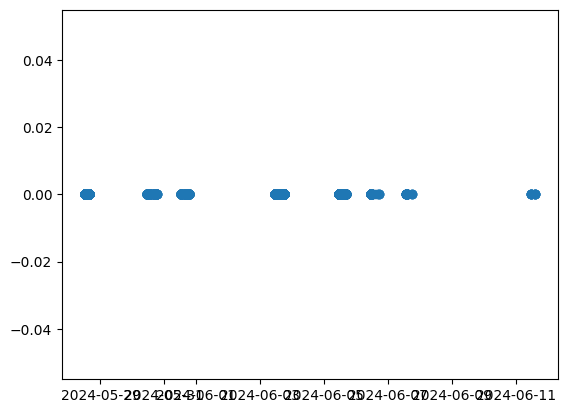

In [111]:
plt.scatter(trs['datetime_UTC'], trs['input_flow_lpm'])

In [109]:
trs = trs[trs['input_flow_lpm']==0]